<a href="https://colab.research.google.com/github/shachimaurya23/Learning/blob/main/PyTorch/Pytorch_learning_ANN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using ANN to Classify Fashion MNIST data

##(MULTICLASS CLASSIFICATION)


In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna

In [2]:
torch.manual_seed(42) # Set random seeds for reproducibility

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
df=pd.read_csv("fashion-mnist_train.csv")
# df=pd.read_csv("fmnist_small.csv")    #smaller subset of the dataset to run
# w/o GPU

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


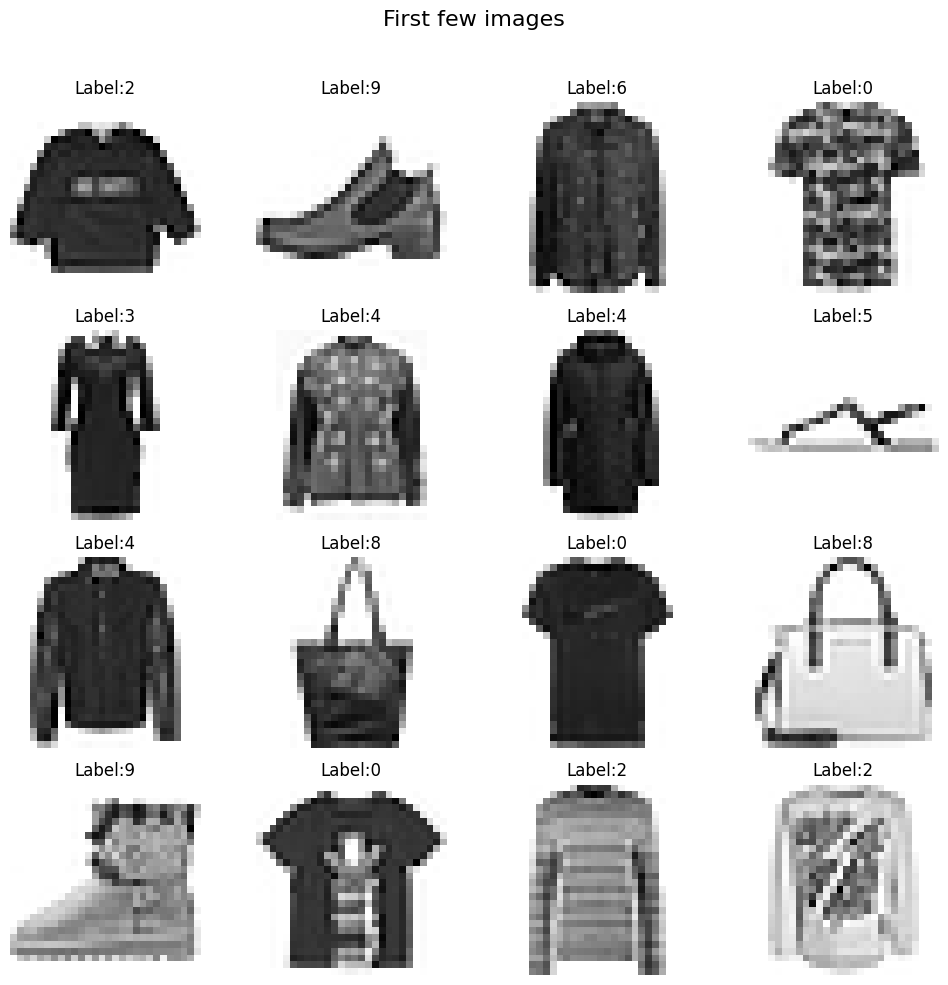

In [6]:
#Visualize the dataset
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First few images",fontsize=16)

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28) #reshape to 28x28
  ax.imshow(img,cmap="binary") #display grayscale
  ax.axis("off")
  ax.set_title(f"Label:{df.iloc[i,0]}")
plt.tight_layout(rect=[0,0,1,0.96]) #adjust layout to fit the title
plt.show()

In [6]:
#train test split
X=df.iloc[:,1:].values
y=df.iloc[:,0].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
#scale the features
X_train=X_train/255.0
X_test=X_test/255.0

In [8]:
#create custom dataset
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [9]:
train_dataset=CustomDataset(X_train,y_train)

In [10]:
test_dataset=CustomDataset(X_test,y_test)

In [11]:
class ANN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [12]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = ANN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  loss_function = nn.CrossEntropyLoss()

  if optimizer_name == 'Adam':
    optimizer=optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optimizer=optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer=optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      y_pred= model(batch_features)

      # calculate loss
      loss = loss_function(y_pred, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0
  accuracy=0
  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      y_pred = model(batch_features)

      _, predicted = torch.max(y_pred, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [13]:
study=optuna.create_study(direction="maximize")
study.optimize(objective,n_trials=10)

[I 2025-02-02 19:13:53,781] A new study created in memory with name: no-name-9f776aaf-1e41-4e31-b4d9-b24d56e7b698
[I 2025-02-02 19:19:25,232] Trial 0 finished with value: 0.8375 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 96, 'epochs': 40, 'learning_rate': 0.0032113091555792395, 'dropout_rate': 0.2, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 0.0004797013513236199}. Best is trial 0 with value: 0.8375.
[I 2025-02-02 19:25:02,108] Trial 1 finished with value: 0.8385 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 72, 'epochs': 50, 'learning_rate': 0.007679045514891872, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 7.053470616924907e-05}. Best is trial 1 with value: 0.8385.
[I 2025-02-02 19:25:31,859] Trial 2 finished with value: 0.8824166666666666 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 120, 'epochs': 30, 'learning_rate': 0.0006684140272792792, 'dropout_rate': 0.4, 'batch_size': 128, 'optimizer

In [14]:
study.best_params

{'num_hidden_layers': 3,
 'neurons_per_layer': 104,
 'epochs': 40,
 'learning_rate': 0.00025892088001234245,
 'dropout_rate': 0.1,
 'batch_size': 32,
 'optimizer': 'Adam',
 'weight_decay': 0.00011355642545481151}

In [15]:
study.best_value

0.8938333333333334

#code w/o optuna

In [19]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,pin_memory=True)

In [27]:
epochs=100
learning_rate=0.1

In [28]:
#instantiate the model
model=ANN(X_train.shape[1])
model.to(device)
#loss function
loss_function=nn.CrossEntropyLoss()
#optimizer
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [29]:
#Training loop
for epoch in range(epochs):
  total_epoch_loss=0
  for batch_features,batch_labels in train_loader:

    # move data to GPU
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    # forward pass
    y_pred=model(batch_features)
    #loss function
    loss=loss_function(y_pred,batch_labels)
    #clear grad
    optimizer.zero_grad()
    #backward pass
    loss.backward()
    #update weights
    optimizer.step()

    total_epoch_loss+=loss.item()
  avg_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch:{epoch+1}, Loss:{avg_loss}")

Epoch:1, Loss:0.6289733699957529
Epoch:2, Loss:0.49750435262918474
Epoch:3, Loss:0.45823923988143606
Epoch:4, Loss:0.44051706813275815
Epoch:5, Loss:0.4186578034510215
Epoch:6, Loss:0.4075774185210466
Epoch:7, Loss:0.3970164604783058
Epoch:8, Loss:0.38432031074166295
Epoch:9, Loss:0.37822355728348095
Epoch:10, Loss:0.36809411137302717
Epoch:11, Loss:0.3623276891658703
Epoch:12, Loss:0.3604793378387888
Epoch:13, Loss:0.35303762258589266
Epoch:14, Loss:0.3504013134886821
Epoch:15, Loss:0.3463756038149198
Epoch:16, Loss:0.34369862158596515
Epoch:17, Loss:0.33903014137595894
Epoch:18, Loss:0.33668675464888415
Epoch:19, Loss:0.333699007699887
Epoch:20, Loss:0.32897973984479906
Epoch:21, Loss:0.3264759483387073
Epoch:22, Loss:0.3254634704341491
Epoch:23, Loss:0.3234037353520592
Epoch:24, Loss:0.319105872814854
Epoch:25, Loss:0.3170106581772367
Epoch:26, Loss:0.3140014426956574
Epoch:27, Loss:0.3111702332446972
Epoch:28, Loss:0.3109444208219647
Epoch:29, Loss:0.3069169324537118
Epoch:30, Loss

In [30]:
model.eval( )

ANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [31]:
#eval_code on test _data
total=0
correct=0
with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    y_pred=model(batch_features)
    _,y_pred=torch.max(y_pred,1)  # as model gives probabilty for each image being label so we find the max of the probability
    total+=batch_labels.shape[0] # size of batch_labels
    correct+=(y_pred==batch_labels).sum().item()
print(correct/total)

0.894


In [32]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9474583333333333


In [ ]:
#eval_code  for when we were using a smaller subset of data and device=cpu
total=0
correct=0
with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    y_pred=model(batch_features)
    _,y_pred=torch.max(y_pred,1)  # as model gives probabilty for each image being label so we find the max of the probability
    total+=batch_labels.shape[0] # size of batch_labels
    correct+=(y_pred==batch_labels).sum().item()
print(correct/total)

0.8325
